In [ ]:
# dataset @ https://finance.yahoo.com/quote/MSFT/history/

# If you want the exact same dataset as the YouTube video,
# use this link: https://drive.google.com/file/d/1WLm1AEYgU28Nk4lY4zNkGPSctdImbhJI/view?usp=sharing

In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from copy import deepcopy
import datetime

In [17]:
# Get the data for the stock MSFT from yfinance
data = yf.download('MSFT', start='1986-01-01', end='2023-12-17')
# Save the data to a CSV file
data.to_csv('MSFT.csv')

[*********************100%***********************]  1 of 1 completed


In [18]:
df = pd.read_csv('MSFT.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060657,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062823,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063907,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062281,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061198,47894400
...,...,...,...,...,...,...,...
9340,2023-04-04,287.230011,290.450012,285.670013,287.179993,287.179993,25824300
9341,2023-04-05,285.850006,287.149994,282.920013,284.339996,284.339996,22064800
9342,2023-04-06,283.209991,292.079987,282.029999,291.600006,291.600006,29770300
9343,2023-04-10,289.209991,289.600006,284.709991,289.390015,289.390015,23079400


In [19]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9340,2023-04-04,287.179993
9341,2023-04-05,284.339996
9342,2023-04-06,291.600006
9343,2023-04-10,289.390015


In [20]:
df['Date']
# Convert the date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

C:\Users\msene\AppData\Local\Temp\ipykernel_60948\759878743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


In [21]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9340,2023-04-04,287.179993
9341,2023-04-05,284.339996
9342,2023-04-06,291.600006
9343,2023-04-10,289.390015


In [22]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-04-04,287.179993
2023-04-05,284.339996
2023-04-06,291.600006


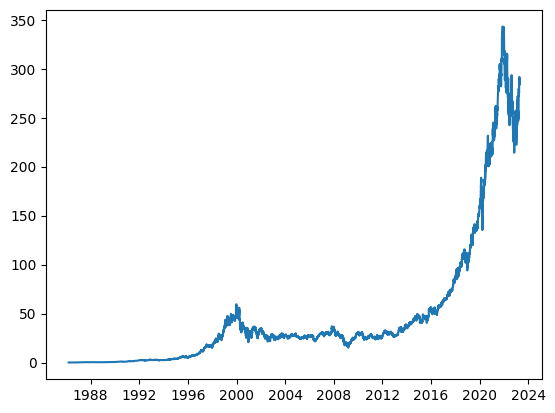

In [26]:

plt.plot(df.index, df['Close'])
plt.show()

In [31]:

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = pd.to_datetime(first_date_str)
  last_date  = pd.to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

In [35]:
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '1986-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1986-03-25,0.095486,0.092882,0.090278,0.092014
1,1986-03-26,0.092882,0.090278,0.092014,0.094618
2,1986-03-27,0.090278,0.092014,0.094618,0.096354
3,1986-03-31,0.092014,0.094618,0.096354,0.095486
4,1986-04-01,0.094618,0.096354,0.095486,0.094618
...,...,...,...,...,...
9069,2022-03-17,276.440002,287.149994,294.390015,295.220001
9070,2022-03-18,287.149994,294.390015,295.220001,300.429993
9071,2022-03-21,294.390015,295.220001,300.429993,299.160004
9072,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [36]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)


In [37]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((9074,), (9074, 3, 1), (9074,))

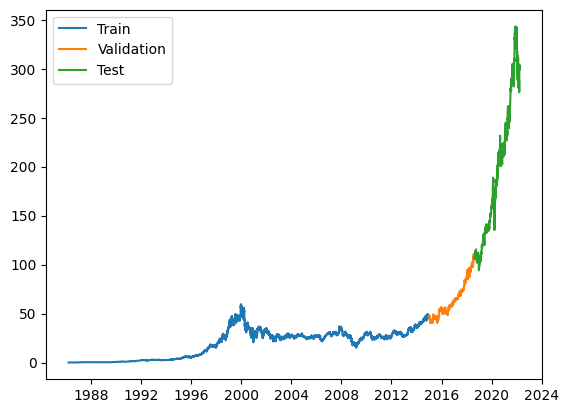

In [38]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

### MODEL TRAINING

In [39]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
227/227 [==============================] - 2s 3ms/step - loss: 96.9641 - mean_absolute_error: 4.4255 - val_loss: 502.2791 - val_mean_absolute_error: 14.9702
Epoch 2/100
227/227 [==============================] - 0s 1ms/step - loss: 0.3551 - mean_absolute_error: 0.3280 - val_loss: 383.5300 - val_mean_absolute_error: 12.2332
Epoch 3/100
227/227 [==============================] - 0s 2ms/step - loss: 0.3294 - mean_absolute_error: 0.3360 - val_loss: 345.4480 - val_mean_absolute_error: 11.3090
Epoch 4/100
227/227 [==============================] - 0s 1ms/step - loss: 0.3291 - mean_absolute_error: 0.3357 - val_loss: 324.9471 - val_mean_absolute_error: 10.8690
Epoch 5/100
227/227 [==============================] - 0s 1ms/step - loss: 0.3195 - mean_absolute_error: 0.3321 - val_loss: 310.5079 - val_mean_absolute_error: 10.4792
Epoch 6/100
227/227 [==============================] - 0s 1ms/step - loss: 0.3128 - mean_absolute_error: 0.3248 - val_loss: 301.1182 - val_mean_absolute_error:

227/227 [==============================] - 0s 612us/step


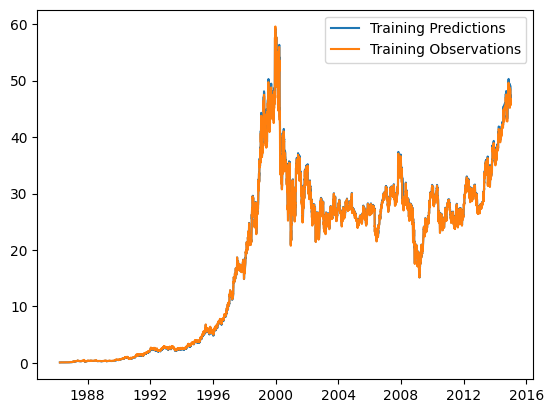

In [40]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

29/29 [==============================] - 0s 1ms/step


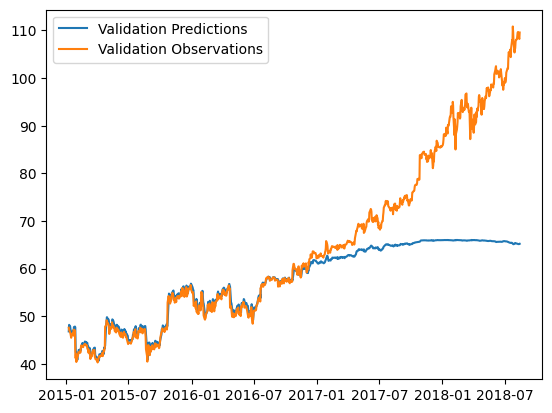

In [41]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

29/29 [==============================] - 0s 674us/step


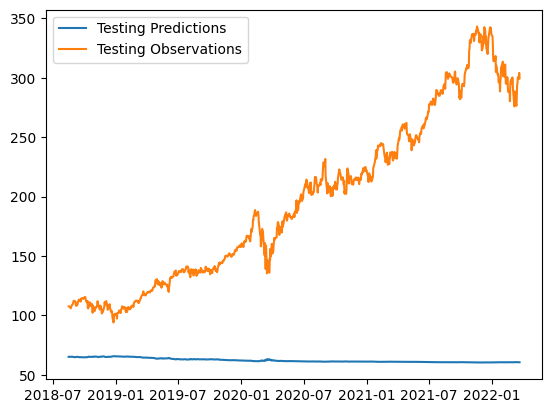

In [42]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

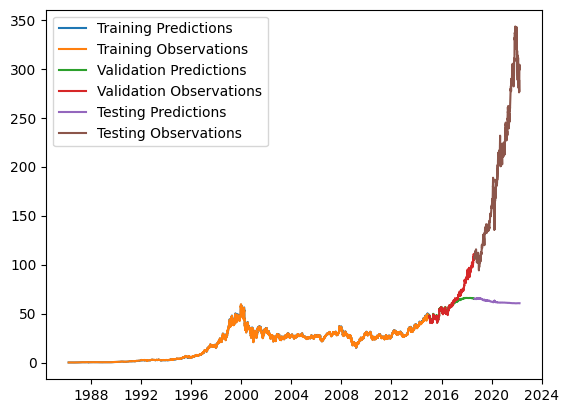

In [43]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [ ]:
recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])